In [112]:
%load_ext autoreload
%autoreload 2

In [111]:
import sys
sys.path.append('../src/')

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
import random

### Environment

* define a grid with holes
* start position in upper left corner and goal in the lower right corner
* win: `position == goal; loss: position != goal`
* `if grid[position] == 0 then position == start`
* `steps == 20`
* `if position == goal then done==True`

In [3]:
grid = np.array([
    [1, 1, 0, 1, 1, 1, 1],
    [0, 1, 0, 1, 1, 0, 1],
    [1, 1, 1, 0, 1, 0, 1],
    [1, 0, 1, 1, 1, 0, 1],
    [1, 1, 1, 1, 0, 0, 1],
    [0, 0, 0, 1, 0, 1, 1],
    [1, 1, 1, 1, 0, 1, 1]
])

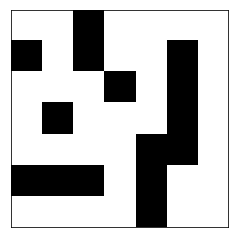

In [13]:
plt.imshow(grid, cmap='gray')
plt.yticks([])
plt.xticks([])
plt.show()

In [32]:
done = False
start = (0,0)
goal = (6,6)
steps = 20
win = False
position = start

In [33]:
moves = np.array([[-1, 0],
                    [1, 0],
                    [0, -1],
                    [0, 1]])

In [34]:
def observe(position):
    idx = np.where((moves + position).min(axis=1) >= 0)[0]
    return [(i,j) for i,j in moves[idx,:]+position if grid[i,j] >= 0]

In [35]:
observe(start)

[(1, 0), (0, 1)]

In [67]:
def action(next_position):
    if grid[next_position] == 0:
        position = start
    elif next_position == goal:
        win = True
    else:
        position = next_position
    return position

In [107]:
possible_positions = observe(position)

In [108]:
next_position = random.choice(possible_positions)

In [109]:
position = action(next_position)

In [110]:
position

(0, 1)

In [113]:
from mcts import GridEnv

In [191]:
wins = 0
for _ in range(10000):
    env = GridEnv()
    for i in range(22):
        if not env.done:
            possible_position = env.observe()
            next_position = random.choice(possible_position)
            env.action(next_position)
            if env.win:
                wins += 1


In [192]:
wins

0

### Monte Carlo Tree Search

* Analysis of the most promizing move toward a goal.
* session are played until the end by selecting random moves
* the session result is used to weight nodes of the actions tree

#### Algorithm

* _Selection_ : choose most promizing child nodes starting from the root _(R)_ of the tree until one of the leaf node _(L)_ of the tree.

* _Expansion_ : if _L_ is not **terminal**, create child nodes from avaliable actions and choose one node _(C)_.

* _Simulation_ : play a random **playout** from _C_

* _Backpropagation_ : use the **result** of the simulation to update nodes' information on the **path** from _C_ to _R_.

### Simulation
Each simulation is run at most **max_moves**

From a given **position** select a **random** move or **UCB1** move from legal positions until the **environment** is **done**.

Each positions are appended to a **path**.

If the legal positions are not known we will **expand** the search tree to include these leaf nodes.

In [275]:
def expand(current, positions):
    g.add_nodes_from(positions, wins=0, plays=0)
    g.add_edges_from([(current, pos) for pos in positions])

In [276]:
env = GridEnv()

In [277]:
start = (0,0)
positions = env.observe()

In [278]:
expand(start, positions)

In [279]:
g.nodes(data=True)

NodeDataView({(0, 0): {'wins': 0, 'plays': 0}, (1, 0): {'wins': 0, 'plays': 0}, (0, 1): {'wins': 0, 'plays': 0}})

In [417]:
max_moves = 10000

In [418]:
g = nx.DiGraph()
g.add_node(start, wins=0, plays=0)
path = []
env = GridEnv()
C = np.sqrt(2)

for t in range(max_moves):
    current = env.position
    possible_positions = env.observe()

    # choose next move
    if not (np.array([(p in g) for p in possible_positions])).all():
#             print('random')
        expand(current, possible_positions)
        position = random.choice(possible_positions)
    else:    
#             print('utc')
        log_nb_sims = np.log(t+1)
        nb_plays = np.array([g.nodes(data=True)[pos]['plays'] for pos in possible_positions]) + 1
        nb_wins = np.array([g.nodes(data=True)[pos]['wins'] for pos in possible_positions]) + 1
        wi_ni = np.divide(nb_wins,nb_plays)
        ln_ni = C * np.sqrt(np.divide(log_nb_sims, nb_plays))
        utc = np.add(wi_ni, ln_ni)
        position = possible_positions[np.argmax(utc)]


    # save path
    path.append(position)

    # update count
    g.nodes(data=True)[position]['plays'] += 1

    # move in the env
    env.action(position)

    # update wins
    if env.win:
        for node in path:
            g.nodes(data=True)[node]['wins'] += 1

In [419]:
g.nodes(data=True)

NodeDataView({(0, 0): {'wins': 3017709, 'plays': 855}, (1, 0): {'wins': 9275447, 'plays': 2628}, (0, 1): {'wins': 9139831, 'plays': 2589}, (1, 1): {'wins': 3110189, 'plays': 881}, (0, 2): {'wins': 3015321, 'plays': 854}, (2, 1): {'wins': 1493985, 'plays': 420}, (1, 2): {'wins': 1633718, 'plays': 459}, (3, 1): {'wins': 553566, 'plays': 154}, (2, 0): {'wins': 475803, 'plays': 132}, (2, 2): {'wins': 473596, 'plays': 131}, (3, 0): {'wins': 471161, 'plays': 132}, (3, 2): {'wins': 244240, 'plays': 67}, (2, 3): {'wins': 215955, 'plays': 60}, (4, 0): {'wins': 461934, 'plays': 128}, (5, 0): {'wins': 225451, 'plays': 63}, (4, 1): {'wins': 241013, 'plays': 67}, (5, 1): {'wins': 204303, 'plays': 53}, (4, 2): {'wins': 144666, 'plays': 37}, (5, 2): {'wins': 110465, 'plays': 28}, (4, 3): {'wins': 96685, 'plays': 25}, (3, 3): {'wins': 142599, 'plays': 37}, (3, 4): {'wins': 80289, 'plays': 20}, (2, 4): {'wins': 36680, 'plays': 7}, (4, 4): {'wins': 32922, 'plays': 8}, (3, 5): {'wins': 39018, 'plays': 6}

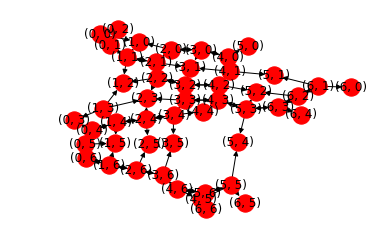

In [420]:
pos = nx.kamada_kawai_layout(g)
nx.draw_networkx_nodes(g,pos)
nx.draw_networkx_labels(g, pos)
nx.draw_networkx_edges(g,pos)
plt.axis('off')
plt.show()